In [21]:
import os
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
sns.set()

# Load and preprocess metadata
- Load data.
- Show raw json data structure.
- Show flattened data into a single pandas dataframe for easy manipulation.

In [2]:
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = '/local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset'

with open(os.path.join(data_dir, 'metadata.json'), 'r') as f:
    orig_metadata = json.load(f)

In [4]:
n_windows = len(orig_metadata)
print(f'Number of windows={n_windows}')
print(f'Structure of each record:')
print(json.dumps(orig_metadata[0], indent=2))

Number of windows=1835006
Structure of each record:
{
  "dynamic": {
    "date_time_format": "%Y-%m-%d_%H-%M-%S",
    "date_time_str": "2022-06-08_10-06-49",
    "frame_idx": 357,
    "num_windows": 100,
    "timestamp": 1654697209.646636,
    "window_idx": 0,
    "window_percent": 0.0
  },
  "static": {
    "extracted_image_size": [
      64,
      64
    ],
    "game_info": {
      "map_name": "Ascension to Aiur LE",
      "mod_names": [
        "Mods/Core.SC2Mod",
        "Mods/Liberty.SC2Mod",
        "Mods/Swarm.SC2Mod",
        "Mods/Void.SC2Mod",
        "Battle.net/Cache/31/c5/31c50d7586eb0e8a0dcb0048ac07cfb05ec3fc0f0dbd57cc0a79559d2470eb47.s2ma"
      ],
      "options": {
        "raw": true,
        "score": true
      },
      "player_info": {
        "player_1": {
          "race_actual": 1,
          "race_requested": 1
        },
        "player_2": {
          "race_actual": 2,
          "race_requested": 2
        }
      },
      "start_raw": {
        "map_size": {
 

In [6]:
metadata = orig_metadata
flat_metadata = pd.json_normalize(metadata, sep='.')
md = flat_metadata # Rename for simplicity

In [7]:
print('LAST ROW\n\n')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # Print all features
    print(md.iloc[-1])

LAST ROW


dynamic.date_time_format                                                                    %Y-%m-%d_%H-%M-%S
dynamic.date_time_str                                                                     2022-06-08_05-53-26
dynamic.frame_idx                                                                                       14855
dynamic.num_windows                                                                                        58
dynamic.timestamp                                                                           1654682006.097222
dynamic.window_idx                                                                                         57
dynamic.window_percent                                                                               0.982759
static.extracted_image_size                                                                          [64, 64]
static.game_info.map_name                                                                          Odyssey LE

In [26]:
# Create game metadata (i.e., ignore dynamic part)
n_unique_replays = len(md['static.replay_name'].unique())
print('Number of unique replays = ', n_unique_replays)
n_window_0 = (md['dynamic.window_idx'] == 0).sum()
print('Number of windows with 0 index = ', n_window_0)
assert n_unique_replays == n_window_0, 'These should be the same'

game_md = copy.deepcopy(md[md['dynamic.window_idx'] == 0])
#game_md.drop(columns=[k for k in game_md.keys() if k.startswith('dynamic.')])

Number of unique replays =  30000
Number of windows with 0 index =  30000


# Display histograms for all numeric features (and some counts)


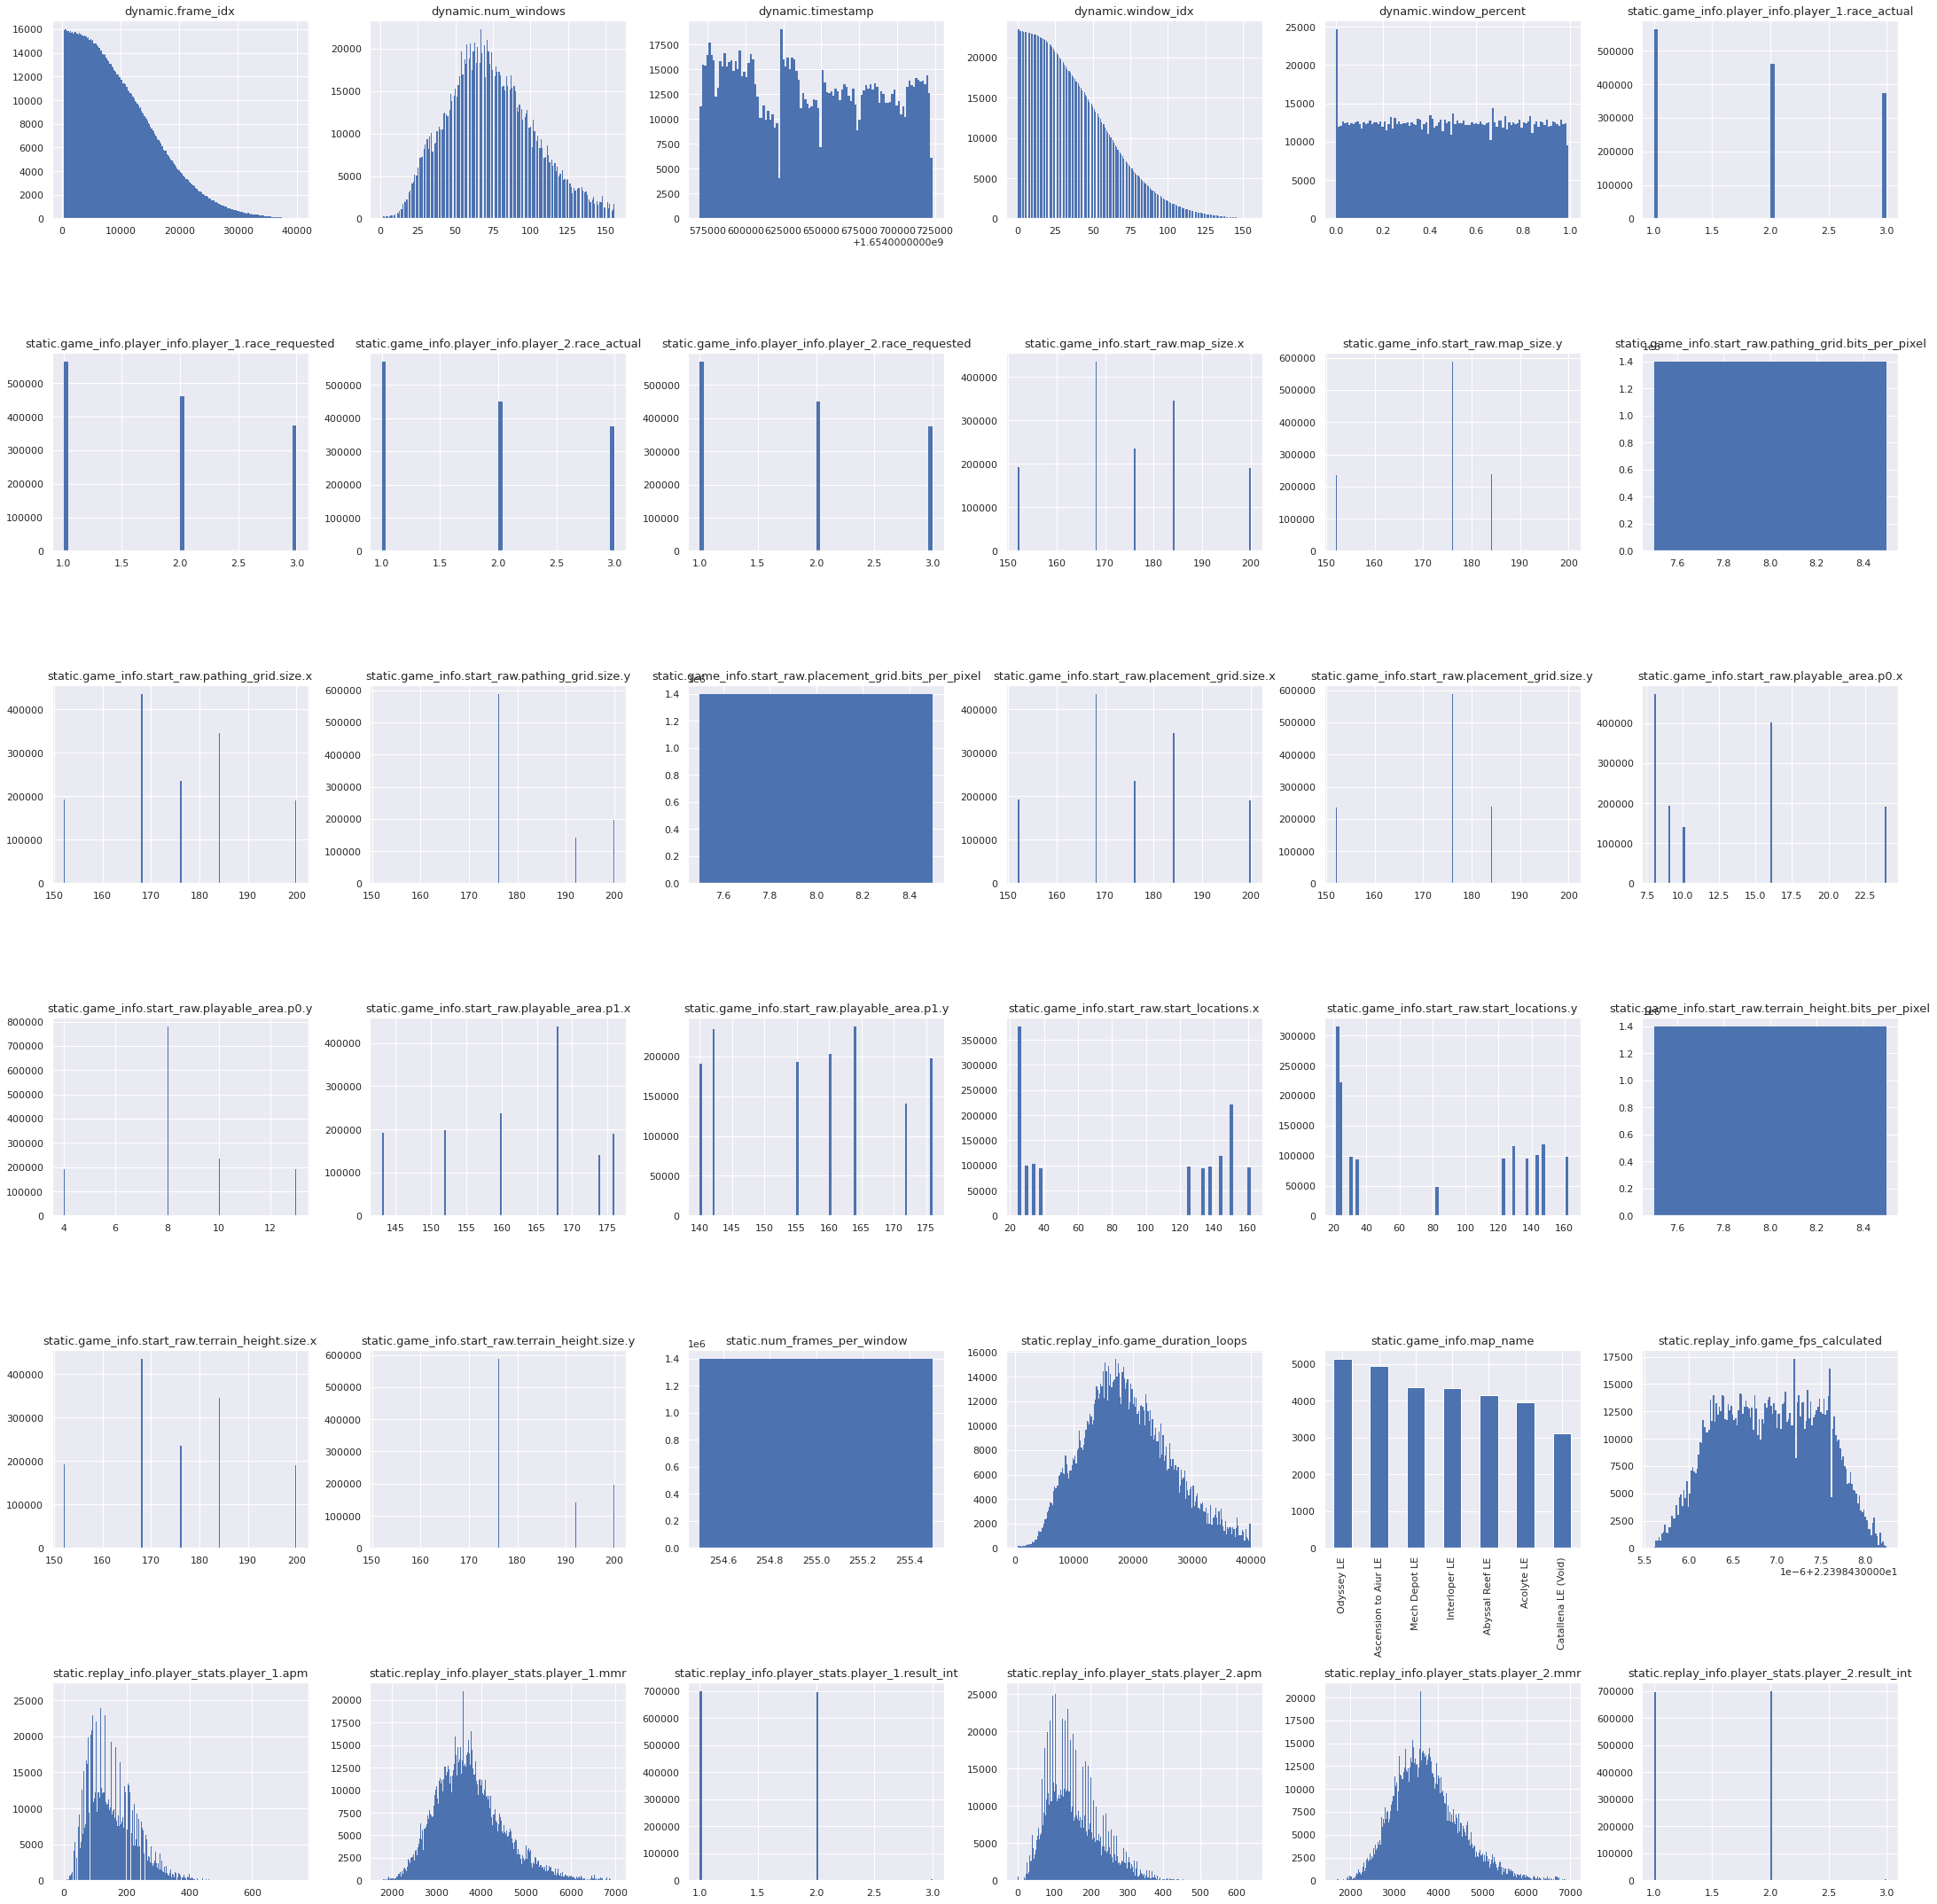

In [165]:
to_plot = md[md['static.replay_info.game_duration_loops'] < 40000]
to_plot = to_plot[to_plot['static.replay_info.player_stats.player_1.mmr']>0]
to_plot = to_plot[to_plot['static.replay_info.player_stats.player_2.mmr']>0]

to_plot = to_plot.drop(columns=['static.replay_info.base_build', 'static.replay_info.data_build'])

fig = to_plot.hist(figsize=[30, 30], bins='auto', linewidth=0)

unique_maps = np.unique(game_md['static.game_info.map_name'])
fig[4,4].clear()
game_md['static.game_info.map_name'].value_counts().plot(kind='bar', ax=fig[4,4])
fig[4,4].set_title('static.game_info.map_name')

_ = [ax.title.set_size(13) for ax in fig.ravel()]
plt.tight_layout()
plt.savefig('metadata_histograms.pdf')
plt.show()

# Map diversity
- Only 7 unique maps but with roughly equal representation among maps!

Number of unique maps =  7


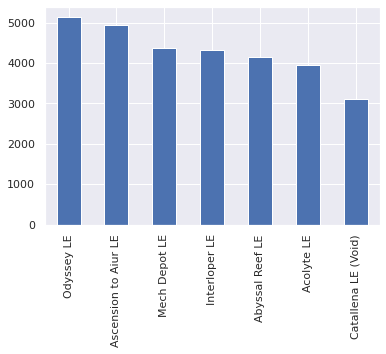

In [75]:
unique_maps = np.unique(game_md['static.game_info.map_name'])
print('Number of unique maps = ', len(unique_maps))
game_md['static.game_info.map_name'].value_counts().plot(kind='bar')
plt.savefig('map-breakdown.pdf')
plt.show()

# Actions Per Minute

Number of games with an APM of 0 =  195


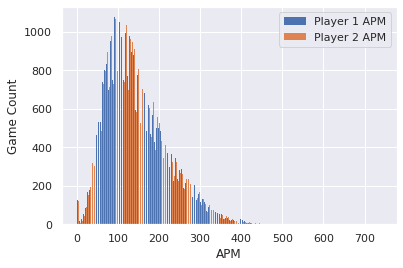

In [18]:
f1 = game_md['static.replay_info.player_stats.player_1.apm']
f2 = game_md['static.replay_info.player_stats.player_2.apm']
plt.hist(np.stack([f1, f2]).T, label=['Player 1 APM', 'Player 2 APM'], bins='auto', linewidth=0)
plt.legend()
plt.xlabel('APM')
plt.ylabel('Game Count')
print('Number of games with an APM of 0 = ', (f1==0).sum() + (f2==0).sum())

Text(0, 0.5, 'Game Count')

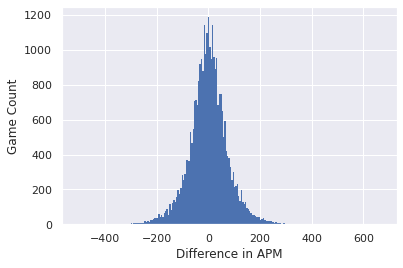

In [19]:
diff = f1 - f2
diff.hist(bins='auto', linewidth=0)
plt.xlabel('Difference in APM')
plt.ylabel('Game Count')

# Relation between higher APM and Winning
- As expected, there is a strong relationship between being faster at the game and winning
- `result=1` == Victory and `result=2` == Defeat

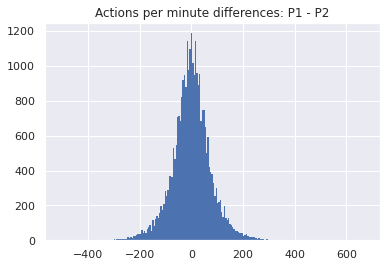

In [20]:
p1_apms = game_md['static.replay_info.player_stats.player_1.apm']
p2_apms = game_md['static.replay_info.player_stats.player_2.apm']
p1_p2_apm_diffs = p1_apms - p2_apms
_ = p1_p2_apm_diffs.hist(bins='auto', linewidth=0).set_title('Actions per minute differences: P1 - P2')

In [21]:
is_p1_winner = game_md['static.replay_info.player_stats.player_1.result'] == 'Win'
is_p1_faster = p1_apms > p2_apms

n_samples = len(game_md)
contingency_table = np.zeros((2,2))

contingency_table[0, 0] = (~is_p1_winner & ~is_p1_faster).sum()
contingency_table[0, 1] = (is_p1_winner & ~is_p1_faster).sum()
contingency_table[1, 0] = (~is_p1_winner & is_p1_faster).sum()
contingency_table[1, 1] = (is_p1_winner & is_p1_faster).sum()
print("""F_0,1 = p1 is slower,faster\nW_0,1 = p1 is loser,winner

[[(F_0, W_0), (F_0, W_1)],
 [(F_1, W_0), (F_1, W_1)]
""")
print(contingency_table)

F_0,1 = p1 is slower,faster
W_0,1 = p1 is loser,winner

[[(F_0, W_0), (F_0, W_1)],
 [(F_1, W_0), (F_1, W_1)]

[[8879. 6216.]
 [6162. 8743.]]


In [22]:
from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-square result: {chi2 :.5g} with p-value of {p: .5g}')

Chi-square result: 915.81 with p-value of  3.5812e-201
